In [ ]:
"""
v2:
dataset:
ignoring labels 1, 3, and 4, retaining only labels 0 (background noise) and label 2 (target class).
background noise (label 0) is downsampled to ensure it matches the number of samples with label 2
split the dataset using torch.utils.data.random_split, into 80% for the training set, 10% for the test set, and 10% for the validation set
model:
loss function modified to (MSE) loss
output: sums the spikes along time dimension
visualize the internal activity

v3:
split the dataset using random_split
Data Augmentation: for train_loader label 1
  time_shift: Shifts the event data along the time axis.
  add_noise: Adds Gaussian noise to event data.
  random_drop: Randomly drops parts of the event data.
add Weights and Biases to track training results
try differnt output: 
output = output.sum(dim=1) ,targets.float().unsqueeze(1)
output = output.mean(dim=1) 
and synnet with different hidden layer
the best model is synnet with 32 hidden layer use augmented data,and mean around each time series. the accuracy rate is 80%

v4: 
output = output.sum(dim=1) +target firing rate tensor
adjust data augmentation parameter(smaller)


v5:
synnet:  dt=10e-3,tau_syn_base/tau_mem/tau_syn_out=0.02
try output="vmem"

v6:
AUC
input and output visualize

"""



'\ndataset: \nignoring labels 1, 3, and 4, retaining only labels 0 (background noise) and label 2 (target class). \nbackground noise (label 0) is downsampled to ensure it matches the number of samples with label 2 \nsplit the dataset using torch.utils.data.random_split, into 80% for the training set, 10% for the test set, and 10% for the validation set\nmodel:\nloss function modified to (MSE) loss \noutput: sums the spikes along time dimension \nvisualize the internal activity \n'

In [2]:
import torch
import numpy as np

# Load tensor
labels_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/labels_tensor.pt")
spikes_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/spike_data_tensor.pt")

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')


Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


/var/folders/kd/vt_v73sx4y5b36zjny3pbn380000gn/T/ipykernel_7952/4283774041.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_tensor = torch.load("/Users/xiaoyuliu/D

# dataset

In [3]:
import torch
import numpy as np

class CCMKDataset(torch.utils.data.Dataset):
    def __init__(self, spikes_tensor, labels_tensor, target_label=2):
        self.spikes_tensor = spikes_tensor
        self.labels_tensor = labels_tensor
        self.target_label = target_label

        # Step 1: Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]

        # Convert the target label (2) to 1 (positive sample)
        self.labels_tensor[self.labels_tensor == target_label] = 1

        # Step 2: Downsample label 0 (background noise) to match the number of target samples (label 2 -> now 1)
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]

        # print samples
        #print(f"Number of label 0 samples before downsampling: {len(label_0_indices)}")
        #print(f"Number of label 1 samples (after converting target label 2 to 1): {len(label_1_indices)}")

        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False))
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False))

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # print data after samples
        print(f"Number of downsampled label 0 samples: {len(selected_label_0_indices)}")
        print(f"Number of target label 1 samples: {len(selected_label_1_indices)}")
        print(f"Balanced dataset length: {len(balanced_indices)}")

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.spikes_tensor[idx], self.labels_tensor[idx]

dataset = CCMKDataset(spikes_tensor=spikes_tensor, labels_tensor=labels_tensor)


Number of downsampled label 0 samples: 1046
Number of target label 1 samples: 1046
Balanced dataset length: 2092
Filtered Labels distribution after processing: tensor([1046, 1046])


# split and dataloader

In [4]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split


# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Print the shape of the first sample in the dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check batch information in the train_loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Calculate and print the labels distribution in each loader

# Training data label distribution
train_labels = torch.cat([batch[1] for batch in train_loader])
print(f'Train Labels distribution: {torch.bincount(train_labels.int())}')

# Validation data label distribution
val_labels = torch.cat([batch[1] for batch in val_loader])
print(f'Validation Labels distribution: {torch.bincount(val_labels.int())}')

# Test data label distribution
test_labels = torch.cat([batch[1] for batch in test_loader])
print(f'Test Labels distribution: {torch.bincount(test_labels.int())}')


Train dataset size: 1672
Test dataset size: 212
Validation dataset size: 208
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Train Labels distribution: tensor([836, 836])
Validation Labels distribution: tensor([104, 104])
Test Labels distribution: tensor([106, 106])


# visulization of input

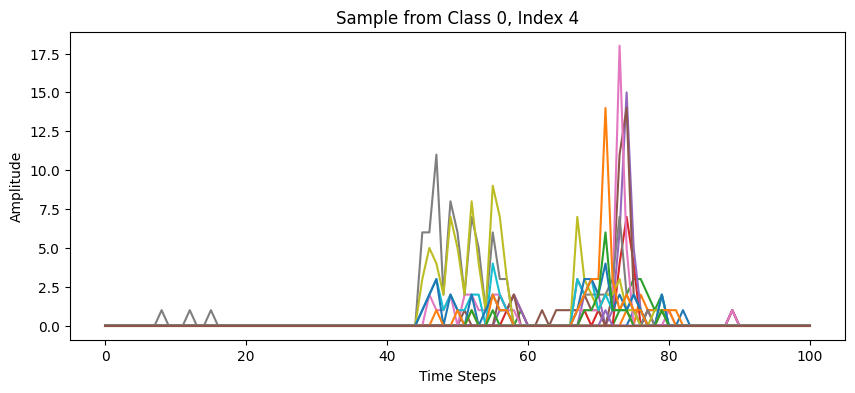

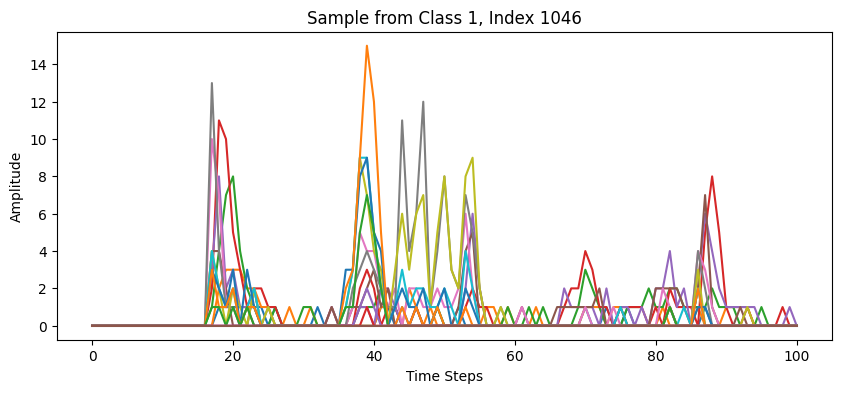

In [70]:
import torch
import matplotlib.pyplot as plt





# Function to visualize a sample
def visualize_sample(spike_data, label, sample_idx):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(spike_data[sample_idx].cpu().numpy().T)  # Transpose to plot over time
    ax.set_title(f"Sample from Class {label}, Index {sample_idx}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Amplitude')

    
    # Show the plot locally
    plt.show()

    # Close the figure to avoid memory leakage
    plt.close(fig)

# Choose sample index from class 0 and class 1
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

# Choose specific indices to visualize
sample_idx_0 = label_0_indices[4]  # Specific sample from class 0
sample_idx_1 = label_1_indices[0]  # Specific sample from class 1

# Visualize class 0 sample and log it to WandB
visualize_sample(dataset.spikes_tensor, label=0, sample_idx=sample_idx_0)

# Visualize class 1 sample and log it to WandB
visualize_sample(dataset.spikes_tensor, label=1, sample_idx=sample_idx_1)



# model-vmem

In [113]:
import inspect
from rockpool.nn.networks import SynNet

synnet_signature = inspect.signature(SynNet.__init__)
print(synnet_signature)


(self, n_classes: int, n_channels: int, size_hidden_layers: List = [60], time_constants_per_layer: List = [10], tau_syn_base: float = 0.002, tau_mem: float = 0.002, tau_syn_out: float = 0.002, quantize_time_constants: bool = True, threshold: float = 1.0, threshold_out: Union[float, List[float]] = None, train_threshold: bool = False, neuron_model: Type = <class 'rockpool.nn.modules.torch.lif_torch.LIFTorch'>, max_spikes_per_dt: int = 31, max_spikes_per_dt_out: int = 1, p_dropout: float = 0.0, dt: float = 0.001, output: str = 'spikes', *args, **kwargs)


In [219]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
dt=10e-3          #rasterization time-step
n_time = 100    # Number of time steps 1/10e-3
batch_size = 32  # Batch size

# Initialize the SynNet model
net = SynNet(
    output="vmem",                        # Use the membrane potential as the output of the network
    p_dropout = 0.1,                      # Dropout proportion to use
    n_channels=16,                # Number of input channels
    n_classes=1,                  # Number of output classes 
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
    dt=10e-3,
    tau_syn_base=0.02,         # at least 2 times more than dt, how long it takes for the synaptic current to decay to a certain fraction  of its peak value.
    tau_mem=0.02,
    tau_syn_out=0.02)
print(net)




SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


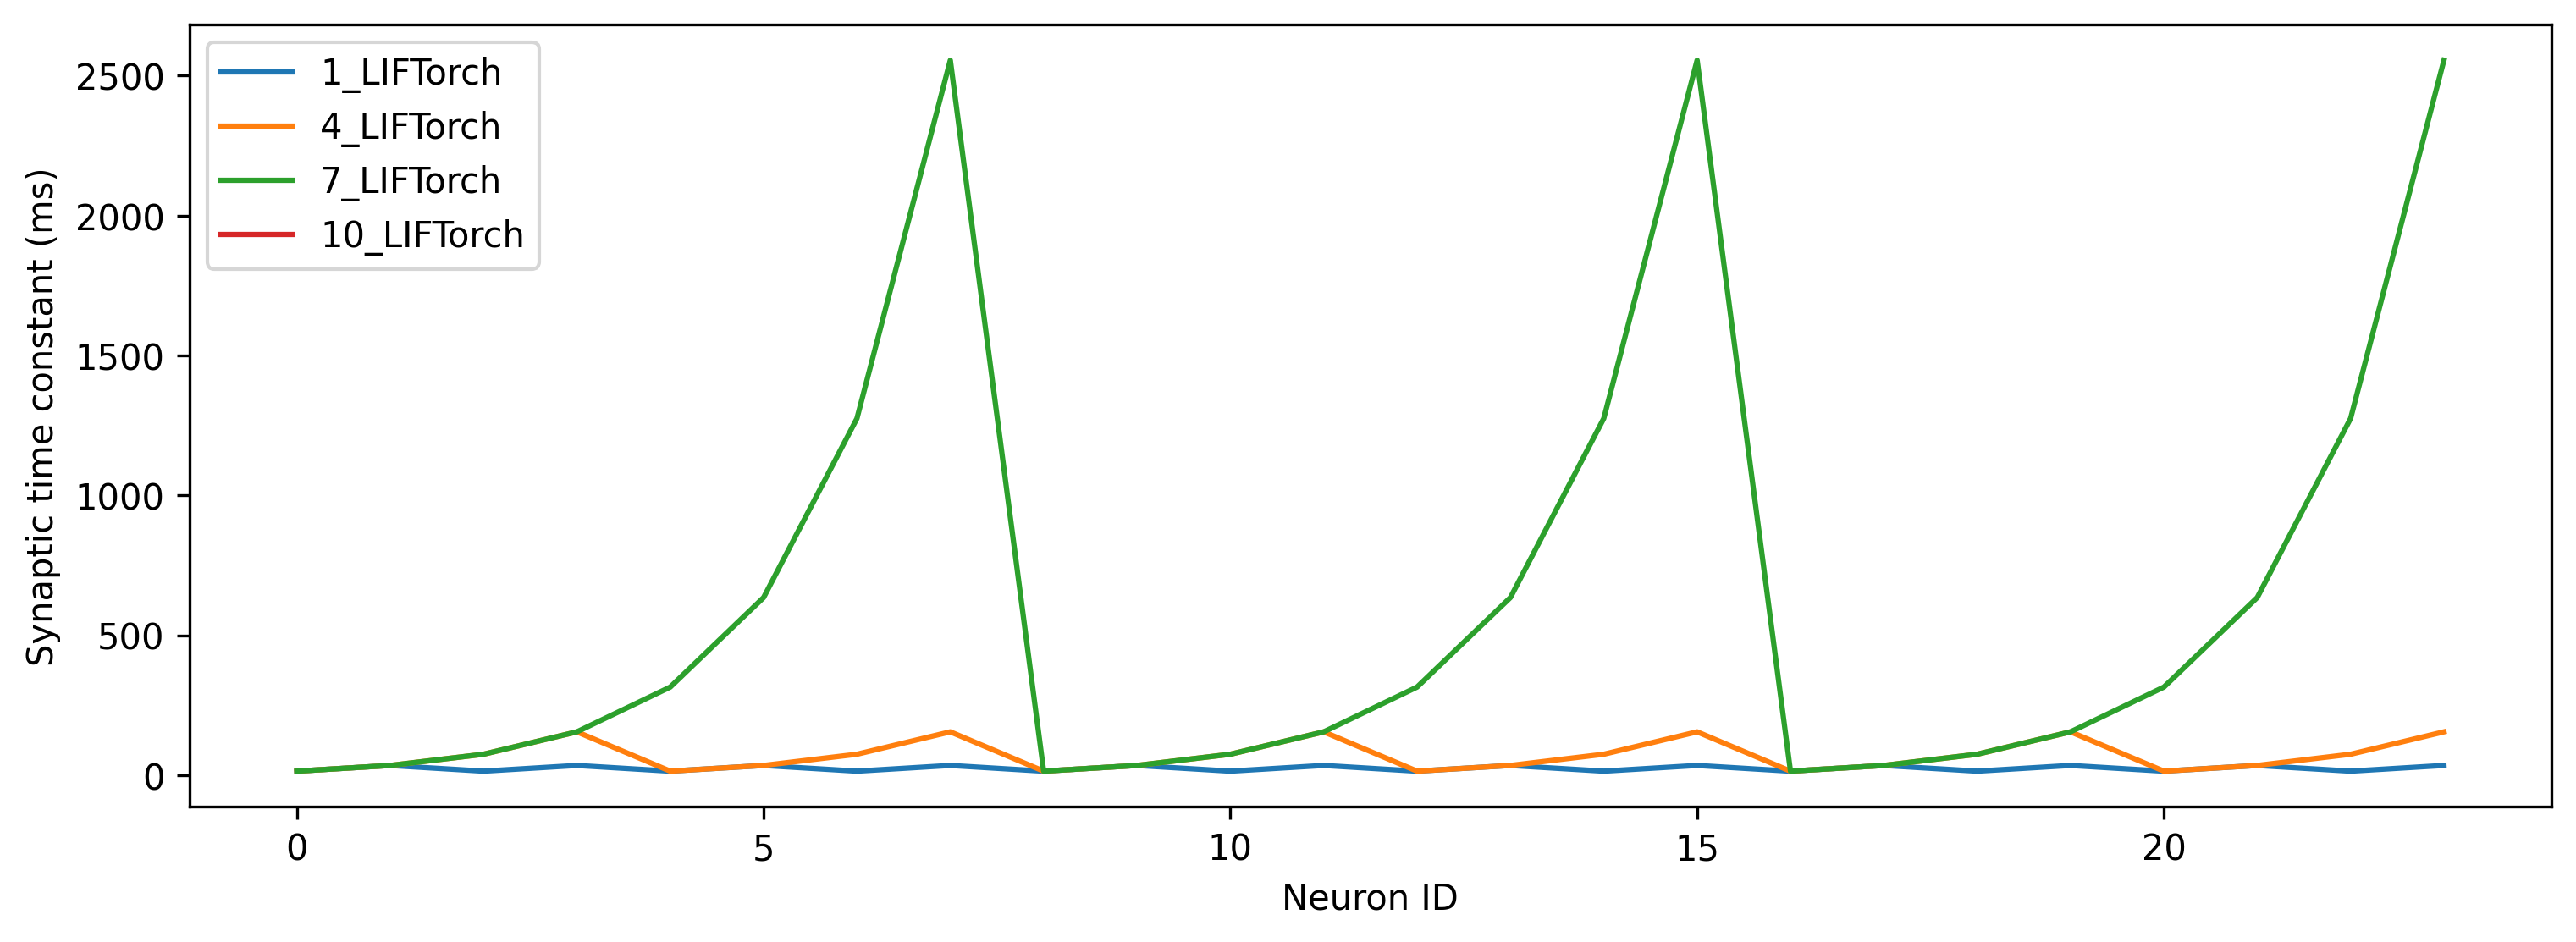

In [93]:
import matplotlib.pyplot as plt

# Plot synaptic time constants for each LIF layer
for lyr_name in net.lif_names:
    tau_syn = net.seq[lyr_name].tau_syn.detach().cpu().numpy() / 1e-3  # Convert to ms
    plt.plot(tau_syn, label=f"{lyr_name}")
    
plt.xlabel("Neuron ID")
plt.ylabel("Synaptic time constant (ms)")
plt.legend()
plt.show()

In [203]:

def set_seed(seed):
    random.seed(seed)              # Set seed for Python random module
    np.random.seed(seed)           # Set seed for NumPy
    torch.manual_seed(seed)        # Set seed for PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)        # Set seed for CUDA
        torch.cuda.manual_seed_all(seed)    # Set seed for all GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [46]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet
from tqdm import trange
import random 
import numpy as np
from sklearn.metrics import roc_curve, auc


In [185]:
import wandb
# Initialize a new W&B run
wandb.login(key="2ac9bb7cd9b60300ecd28184faa02b29add8e82b")

False

In [68]:
import os
os.environ["WANDB_HTTP_TIMEOUT"] = "300"  # 设置超时时间为300秒


In [71]:
wandb.init(
    project="snn_v6", 
    config={
    "learning_rate": 1e-4,
    "epochs": 20,
    "batch_size": 32,}, 
    name="vmem", mode="offline")
# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size

CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [226]:
#target_vmem_value = 0.4
#background_vmem_value = -0.03
target_vmem_value = 0.015  # 尽可能位于两个类别的中间
background_vmem_value = -0.005  # 或者 -0.01，根据 `label 0` 的分布

# Function to calculate accuracy 
def calculate_accuracy_vmem(model, data_loader, target_vmem_value):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements

            outputs, _, _ = net(inputs, record=True)
        
            vmem = net._record_dict[net.label_last_LIF]["vmem"]
            outputs = vmem.sum(dim=1)

            # Create target vmem
            target_vmem = torch.zeros_like(outputs).to(outputs.device)
            target_vmem[targets == 1] = target_vmem_value  
            target_vmem[targets == 0] = background_vmem_value  

            # Use sigmoid activation and classify as 1 if output is above 0.5
            predictions = (torch.sigmoid(outputs) > 0.5).float()  


            # Compare predictions with target firing rate (binary form)
            binary_target = (target_vmem == target_vmem_value).float()

            correct += (predictions == binary_target).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

In [220]:


# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()
n_epochs = 50
seed = 42
set_seed(seed)



# Training and Validation loop
for epoch in range(n_epochs):
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)

        # Forward pass through the network
        outputs, _, _ = net(inputs, record=True)  # Output shape [batch_size, n_time, n_classes]
        #print(net._record_dict)  
              
        vmem = net._record_dict[net.label_last_LIF]["vmem"]
        outputs_sum = vmem.sum(dim=1)  # Sum spikes over the time dimension

        # Create target vmem
        target_vmem = torch.zeros_like(outputs_sum).to(outputs.device)
        target_vmem[targets == 1] = target_vmem_value  
        target_vmem[targets == 0] = background_vmem_value  

        # Compute the loss using target firing rate
        loss = loss_fun(outputs_sum, target_vmem)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = net(inputs, record=True)
            vmem = net._record_dict[net.label_last_LIF]["vmem"]
            outputs_sum = vmem.sum(dim=1)

            # Create target vmem
            target_vmem = torch.zeros_like(outputs_sum).to(outputs.device)
            target_vmem[targets == 1] = target_vmem_value  
            target_vmem[targets == 0] = background_vmem_value  

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_vmem)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_vmem(net, val_loader,target_vmem_value)

    # Log training loss, validation loss, and accuracy to W&B
    #wandb.log({
        #"epoch": epoch + 1,
       # "train_loss": avg_train_loss,
       # "val_loss": avg_val_loss,
       # "val_accuracy": val_accuracy
   # })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on test data
test_accuracy = calculate_accuracy_vmem(net, test_loader, target_vmem_value)



# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/50, Training Loss: 157.0432955184073, Validation Loss: 57.656392506190706, Validation Accuracy: 45.19%
Epoch 2/50, Training Loss: 116.52794490670259, Validation Loss: 52.814558846609934, Validation Accuracy: 62.50%
Epoch 3/50, Training Loss: 63.638514550227036, Validation Loss: 29.886690412248885, Validation Accuracy: 62.02%
Epoch 4/50, Training Loss: 15.170970174501527, Validation Loss: 22.158692632402694, Validation Accuracy: 61.06%
Epoch 5/50, Training Loss: 15.96620752676478, Validation Loss: 24.13961430958339, Validation Accuracy: 59.62%
Epoch 6/50, Training Loss: 33.917107703550805, Validation Loss: 34.11222573689052, Validation Accuracy: 62.50%
Epoch 7/50, Training Loss: 28.974233948959494, Validation Loss: 21.31351477759225, Validation Accuracy: 59.13%
Epoch 8/50, Training Loss: 32.26197945171932, Validation Loss: 27.400177001953125, Validation Accuracy: 63.94%
Epoch 9/50, Training Loss: 36.01768788751566, Validation Loss: 21.46482535770961, Validation Accuracy: 56.73%


In [222]:
from sklearn.metrics import roc_curve, auc

def calculate_auc_vmem(model, data_loader):
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.transpose(1, 2).to(device)  # Ensure input is on the right device
            labels = labels.to(device)  # Ensure labels are on the right device

            # Forward pass through the network
            outputs, _, _ = model(inputs, record=True)
            vmem = model._record_dict[model.label_last_LIF]["vmem"]
            outputs_sum = vmem.sum(dim=1)  # Sum membrane potential over the time dimension

            # Collect outputs and labels for AUC computation
            test_outputs.extend(outputs_sum.cpu().numpy())  # Move to CPU and convert to numpy
            test_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

    # Convert collected outputs and labels to numpy arrays for further processing
    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Compute False Positive Rate, True Positive Rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs)
    # Calculate the AUC (Area Under Curve) based on the ROC curve
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


fpr, tpr, roc_auc = calculate_auc_vmem(net, test_loader)
print(f"AUC Score: {roc_auc}")


AUC Score: 0.6414204343182629


In [ ]:
# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Log the AUC value to W&B
wandb.log({"ROC AUC": roc_auc})


# Save the model
torch.save(net.state_dict(), "model_vmem.pth")
wandb.save("model_vmem.pth")

# Finish the W&B run
wandb.finish()

## visualize output

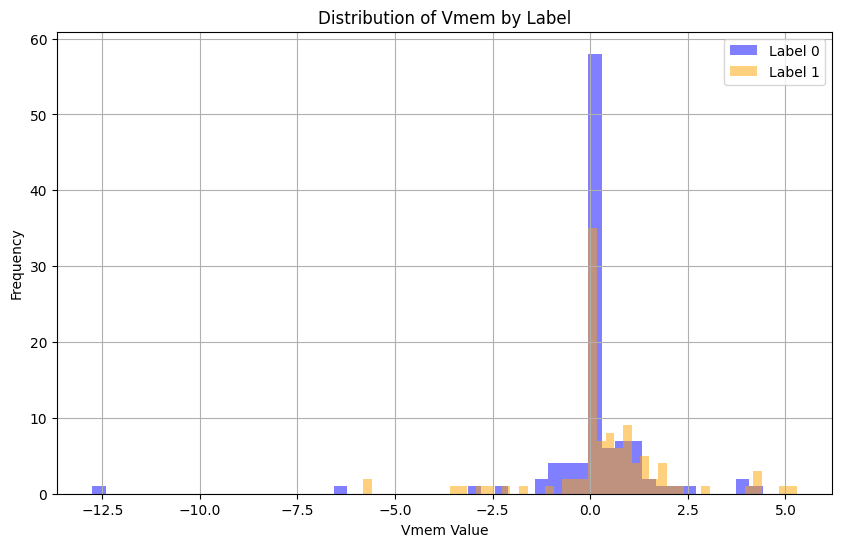

In [223]:
import matplotlib.pyplot as plt

def plot_vmem_distribution(model, data_loader):
    model.eval()
    vmem_class_0 = []
    vmem_class_1 = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.transpose(1, 2).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, _, _ = model(inputs, record=True)
            vmem = model._record_dict[model.label_last_LIF]["vmem"]
            outputs_sum = vmem.sum(dim=1)

            # Separate vmem based on labels and flatten the list
            vmem_class_0.extend(outputs_sum[labels == 0].cpu().numpy().flatten())
            vmem_class_1.extend(outputs_sum[labels == 1].cpu().numpy().flatten())

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(vmem_class_0, bins=50, alpha=0.5, color='blue', label='Label 0')
    plt.hist(vmem_class_1, bins=50, alpha=0.5, color='orange', label='Label 1')
    plt.title("Distribution of Vmem by Label")
    plt.xlabel("Vmem Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot vmem distribution for validation set
plot_vmem_distribution(net, val_loader)


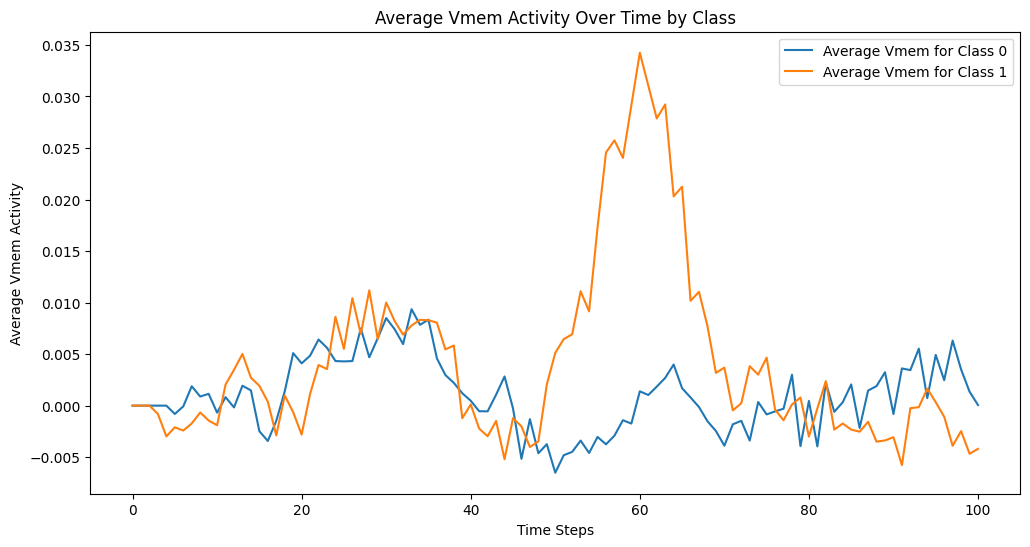

In [224]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_average_vmem(model, data_loader):
    model.eval()
    vmem_by_class = {0: [], 1: []}

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2).to(inputs.device)  # Transpose to match model input shape
            targets = targets.to(inputs.device)
            outputs, _, _ = model(inputs, record=True)
            
            # Extract vmem from model's record
            vmem = model._record_dict[model.label_last_LIF]["vmem"].cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Separate vmem by class
            for i, label in enumerate(targets_np):
                vmem_by_class[label].append(vmem[i])

    # Calculate average vmem over time for each class
    avg_vmem_class_0 = np.mean(vmem_by_class[0], axis=0)
    avg_vmem_class_1 = np.mean(vmem_by_class[1], axis=0)

    # Plot average vmem activity over time
    plt.figure(figsize=(12, 6))
    plt.plot(avg_vmem_class_0, label='Average Vmem for Class 0')
    plt.plot(avg_vmem_class_1, label='Average Vmem for Class 1')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Vmem Activity')
    plt.title('Average Vmem Activity Over Time by Class')
    plt.legend()
    plt.show()

# Visualize average vmem for the validation set
visualize_average_vmem(net, val_loader)


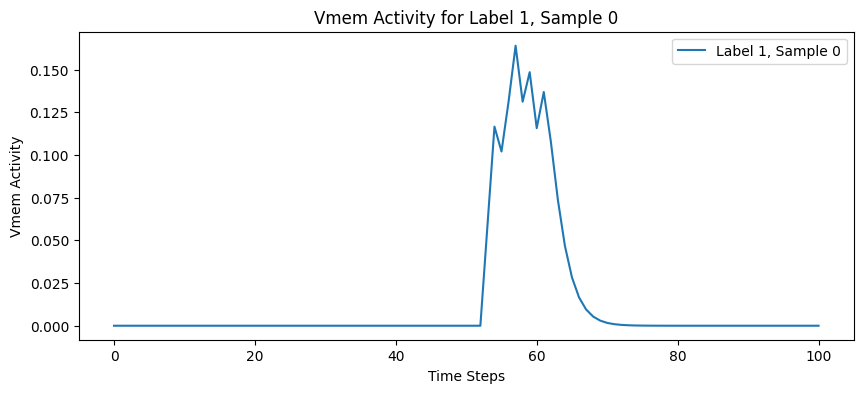

In [225]:
def visualize_vmem_activity(vmem_data, labels, label, sample_idx):
    # Get indices for the specified label
    label_indices = torch.where(labels == label)[0]

    # Ensure the sample index is within the bounds for the specified label
    if len(label_indices) == 0:
        print(f"No samples found for label {label} in the current batch.")
        return
    elif sample_idx >= len(label_indices):
        print(f"Error: sample_idx out of range for label {label}. Max index: {len(label_indices) - 1}")
        return
    
    # Select the index of the sample within the label
    actual_sample_idx = label_indices[sample_idx]

    # Get the vmem data for this sample
    sample_vmem_data = vmem_data[actual_sample_idx]

    # Create figure
    plt.figure(figsize=(10, 4))
    plt.plot(sample_vmem_data.cpu().numpy(), label=f"Label {label}, Sample {sample_idx}")
    plt.title(f"Vmem Activity for Label {label}, Sample {sample_idx}")
    plt.xlabel('Time Steps')
    plt.ylabel('Vmem Activity')
    plt.legend()
    plt.show()

# Select a label and a sample index
label_to_plot = 1  # Class label to visualize
sample_idx_to_plot = 0  # The first sample index for class 1

# Find the first batch that contains the specified label
found = False
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.transpose(1, 2).to(inputs.device)
        targets = targets.to(inputs.device)
        
        outputs, _, _ = net(inputs, record=True)
        vmem = net._record_dict[net.label_last_LIF]["vmem"]  # Extract vmem from model's record

        # Check if the batch contains the specified label
        if label_to_plot in targets:
            visualize_vmem_activity(vmem, targets, label=label_to_plot, sample_idx=sample_idx_to_plot)
            found = True
            break  # Visualize only the first found batch


# model-spikes

In [125]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
dt=10e-3          #rasterization time-step
n_time = 100    # Number of time steps 1/10e-3
batch_size = 32  # Batch size

# Initialize the SynNet model
net.s = SynNet(
    p_dropout = 0.1,                      # Dropout proportion to use
    n_channels=16,                # Number of input channels
    n_classes=1,                  # Number of output classes 
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
    dt=10e-3,
    tau_syn_base=0.02,         # at least 2 times more than dt, how long it takes for the synaptic current to decay to a certain fraction  of its peak value.
    tau_mem=0.02,
    tau_syn_out=0.02)
print(net.s)

SynNet 's' with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [ ]:

wandb.init(project="SNN_v5", config={
    "learning_rate": 1e-4,
    "epochs": 100,
    "batch_size": 32,
}, name="1e-4")
# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size

In [120]:
def calculate_accuracy_s(model, data_loader, threshold=14):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Apply threshold to determine predictions
            predictions = (outputs_sum > threshold).float()

            # Correctly count matches between predictions and targets
            correct += (predictions.squeeze() == targets.float()).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy


In [127]:
def calculate_accuracy_with_sigmoid(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Apply sigmoid activation
            probabilities = torch.sigmoid(outputs_sum)

            # Use a default threshold of 0.5 for classification
            predictions = (probabilities > 0.5).float()

            # Correctly count matches between predictions and targets
            correct += (predictions.squeeze() == targets.float()).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy


In [143]:

# Define the loss function and optimizer
optimizer = Adam(net.s.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()
n_epochs = 100
set_seed(seed)



# Training and Validation loop
for epoch in range(n_epochs):
    net.s.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)

        # Forward pass through the network
        outputs, _, _ = net.s(inputs)  # Output shape [batch_size, n_time, n_classes]
        outputs_sum = outputs.sum(dim=1)  # Sum spikes over the time dimension
        #outputs_prob = torch.sigmoid(outputs_sum)


        # Create target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
        target_firing_rate[targets == 1] = 10  # Set firing rate for positive class
        target_firing_rate[targets == 0] = 0   # Set firing rate for negative class

        # Compute the loss using target firing rate
        loss = loss_fun(outputs_sum, target_firing_rate)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.s.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = net.s(inputs)
            outputs_sum = outputs.sum(dim=1)
            #outputs_prob = torch.sigmoid(outputs_sum)


            # Create target firing rate tensor for validation
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = 10 # Firing rate for positive class
            target_firing_rate[targets == 0] = 0   # Firing rate for negative class

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_with_sigmoid(net.s, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    #wandb.log({
       # "epoch": epoch + 1,
       # "train_loss": avg_train_loss,
       # "val_loss": avg_val_loss,
       # "val_accuracy": val_accuracy
   # })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on test data
test_accuracy = calculate_accuracy_with_sigmoid(net.s, test_loader)

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')






Epoch 1/100, Training Loss: 36.652122641509436, Validation Loss: 39.223214285714285, Validation Accuracy: 71.63%
Epoch 2/100, Training Loss: 35.60849056603774, Validation Loss: 39.941964285714285, Validation Accuracy: 71.63%
Epoch 3/100, Training Loss: 36.865566037735846, Validation Loss: 36.785714285714285, Validation Accuracy: 70.19%
Epoch 4/100, Training Loss: 35.51474056603774, Validation Loss: 39.325892857142854, Validation Accuracy: 72.12%
Epoch 5/100, Training Loss: 35.424528301886795, Validation Loss: 37.22767857142857, Validation Accuracy: 72.12%
Epoch 6/100, Training Loss: 34.431603773584904, Validation Loss: 38.38392857142857, Validation Accuracy: 72.60%
Epoch 7/100, Training Loss: 35.044221698113205, Validation Loss: 37.857142857142854, Validation Accuracy: 72.60%
Epoch 8/100, Training Loss: 34.330778301886795, Validation Loss: 38.70982142857143, Validation Accuracy: 73.56%
Epoch 9/100, Training Loss: 33.96875, Validation Loss: 36.91517857142857, Validation Accuracy: 71.63%

In [144]:
from sklearn.metrics import roc_curve, auc

def calculate_auc_s(model, data_loader):
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.transpose(1, 2).to(device)  # Ensure input is on the right device
            labels = labels.to(device)  # Ensure labels are on the right device

            # Forward pass through the network
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1)  # Sum spikes over the time dimension

            # Convert to probabilities
            outputs_prob = torch.sigmoid(outputs_sum).cpu().numpy()

            # Flatten outputs_prob in case it has extra dimensions
            test_outputs.extend(outputs_prob.flatten())  # Add probabilities to the list
            test_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

    # Convert collected outputs and labels to numpy arrays for further processing
    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Compute False Positive Rate, True Positive Rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs)
    # Calculate the AUC (Area Under Curve) based on the ROC curve
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# Calculate and print AUC
fpr, tpr, roc_auc = calculate_auc_s(net.s, test_loader)
print(f"AUC Score: {roc_auc:.4f}")


AUC Score: 0.8822


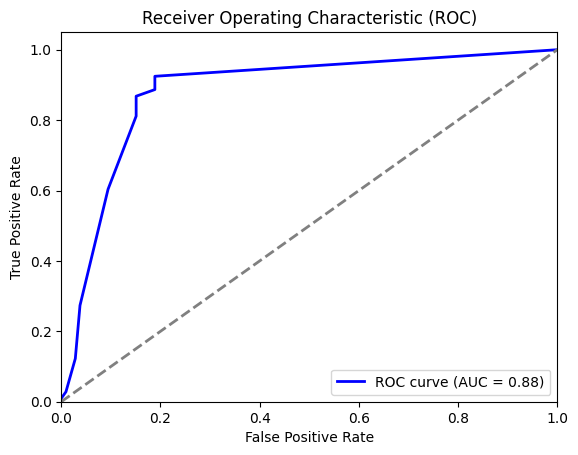

In [145]:
import matplotlib.pyplot as plt
def plot_auc_s(model, data_loader):
    fpr, tpr, roc_auc = calculate_auc_s(model, data_loader)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_auc_s(net.s, test_loader)  



In [ ]:
# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
torch.save(net.s.state_dict(), "model_sum_gt_1e-4.pth")
wandb.save("model_sum_gt_1e.pth")

# Finish the W&B run
wandb.finish()

## visualize output

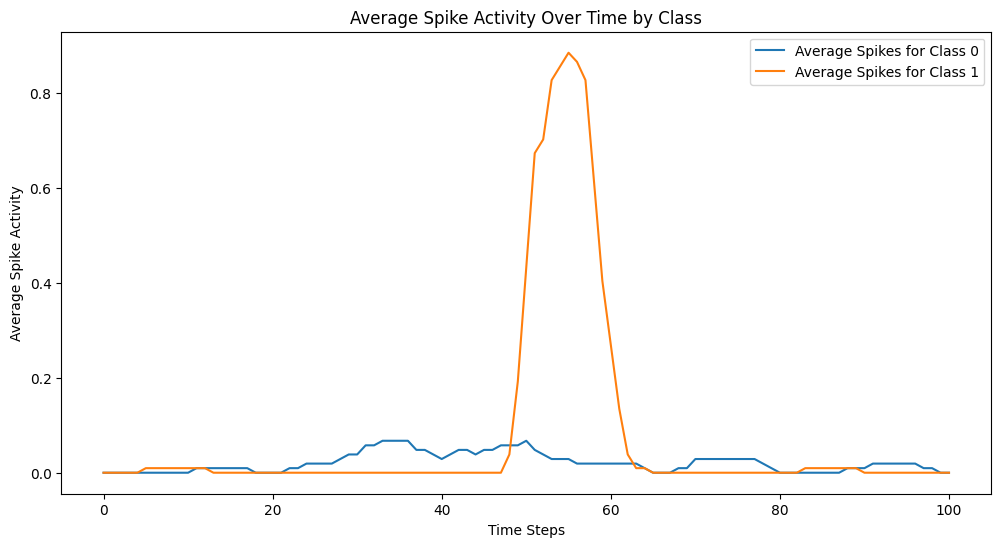

In [146]:
def visualize_average_spikes(model, data_loader):
    model.eval()
    spikes_by_class = {0: [], 1: []}

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Transpose to match model input shape
            outputs, _, _ = model(inputs)
            outputs_np = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Separate spikes by class
            for i, label in enumerate(targets_np):
                spikes_by_class[label].append(outputs_np[i])

    # Calculate average spikes over time for each class
    avg_spikes_class_0 = np.mean(spikes_by_class[0], axis=0)
    avg_spikes_class_1 = np.mean(spikes_by_class[1], axis=0)

    # Plot average spike activity over time
    plt.figure(figsize=(12, 6))
    plt.plot(avg_spikes_class_0, label='Average Spikes for Class 0')
    plt.plot(avg_spikes_class_1, label='Average Spikes for Class 1')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Spike Activity')
    plt.title('Average Spike Activity Over Time by Class')
    plt.legend()
    plt.show()

# Visualize average spikes for the validation set
visualize_average_spikes(net.s, val_loader)


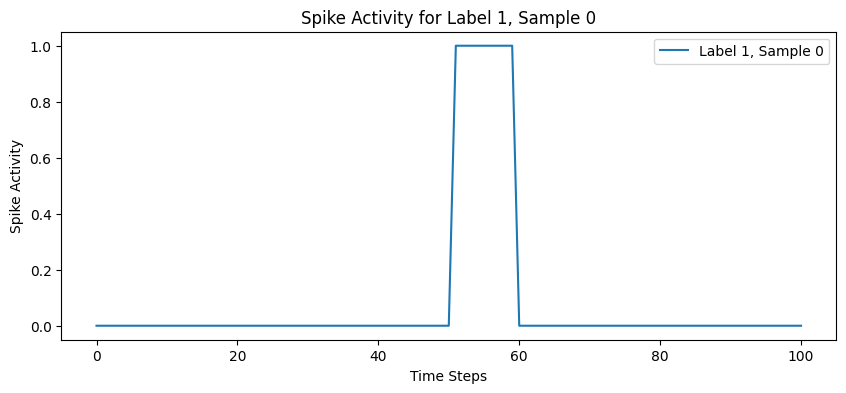

In [147]:
import matplotlib.pyplot as plt
import torch

# Function to visualize a single sample's spike output over time
def visualize_spike_activity(spike_data, labels, label, sample_idx):
    # Get indices for the specified label
    label_indices = torch.where(labels == label)[0]

    # Ensure the sample index is within the bounds for the specified label
    if sample_idx >= len(label_indices):
        print(f"Error: sample_idx out of range for label {label}. Max index: {len(label_indices) - 1}")
        return
    
    # Select the index of the sample within the label
    actual_sample_idx = label_indices[sample_idx]

    # Get the spike data for this sample
    sample_spike_data = spike_data[actual_sample_idx]

    # Create figure
    plt.figure(figsize=(10, 4))
    plt.plot(sample_spike_data.cpu().numpy(), label=f"Label {label}, Sample {sample_idx}")
    plt.title(f"Spike Activity for Label {label}, Sample {sample_idx}")
    plt.xlabel('Time Steps')
    plt.ylabel('Spike Activity')
    plt.legend()
    plt.show()

# Example usage
# Here `outputs` is your spike outputs tensor, and `targets` are your labels
# Select a label and a sample index
label_to_plot = 1  # For example, class 1
sample_idx_to_plot = 0  # The first sample for class 1

visualize_spike_activity(outputs, targets, label=label_to_plot, sample_idx=sample_idx_to_plot)


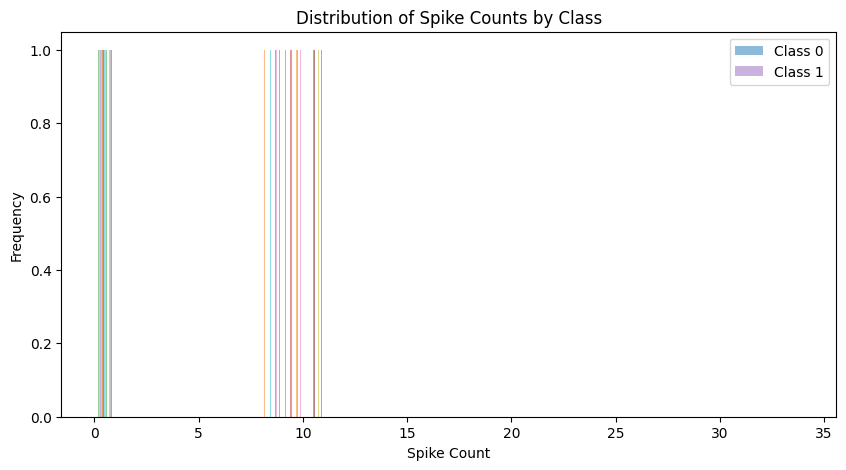

In [148]:
#to check a suitable target firing rate
import matplotlib.pyplot as plt

def plot_spike_count_distribution(model, data_loader):
    model.eval()
    spike_counts_0 = []
    spike_counts_1 = []

    # Gather spike counts for each class
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Adjust input dimensions
            outputs, _, _ = model(inputs)
            outputs_sum = outputs.sum(dim=1).cpu().numpy()  # Sum spikes over time and move to CPU

            # Separate spike counts based on their labels
            spike_counts_0.extend(outputs_sum[targets == 0].tolist())
            spike_counts_1.extend(outputs_sum[targets == 1].tolist())

    # Plot distributions
    plt.figure(figsize=(10, 5))
    plt.hist(spike_counts_0, bins=np.arange(0, 35, 1), alpha=0.5, label='Class 0')  # Setting bins with width 1
    plt.hist(spike_counts_1, bins=np.arange(0, 35, 1), alpha=0.5, label='Class 1')  # Setting bins with width 1
    plt.xlabel('Spike Count')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title('Distribution of Spike Counts by Class')
    plt.show()

# Call the function to plot distribution
plot_spike_count_distribution(net.s, val_loader)

# Data augmentation


training and validation loss are similar through epochs, and validation accuracy drops and fluctuates
test accuracy is higher than validation accuracy

In [ ]:
# Time shift function：Shifts the event data along the time axis.
# Add noise function：Adds Gaussian noise to event data.
# Random drop function：Randomly drops parts of the event data.



In [52]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# Data augmentation functions

# Time shift function：Shifts the event data along the time axis.
def time_shift(event_data, max_shift=2):
    shift = np.random.randint(-max_shift, max_shift)  # Randomly choose a shift amount
    return np.roll(event_data, shift, axis=0)  # Apply shift along the time axis

# Add noise function：Adds Gaussian noise to event data.
def add_noise(event_data, noise_factor=0.001):
    noise = np.random.normal(0, noise_factor, event_data.shape)  # poison noise
    return event_data + noise  # Add noise to the data

# Random drop function：Randomly drops parts of the event data.
def random_drop(event_data, drop_rate=0.05):
    mask = np.random.binomial(1, 1 - drop_rate, event_data.shape)  # Generate a mask to randomly drop parts of the data
    return event_data * mask  # Apply the mask to the data

augmentation_funcs = [time_shift, add_noise, random_drop]

# Combine augmentation functions
def augment_data(event_data, augmentation_funcs):
    for func in augmentation_funcs:
        event_data = func(event_data)  # Apply each augmentation function in sequence
    return event_data

# Data loader with augmentation applied to label 1 (event call) samples
def augment_train_data(train_loader):
    for batch_idx, (data, labels) in enumerate(train_loader):
        for i in range(data.shape[0]):
            if labels[i] == 1:  # Only augment data with label 1
                augmented_data = augment_data(data[i].numpy(), augmentation_funcs)
                data[i] = torch.from_numpy(augmented_data).to(data[i].device)
        yield data, labels



In [46]:
train_loader_augmented=augment_train_data(train_loader)
train_labels_augmented = torch.cat([batch[1] for batch in train_loader_augmented])
print(f'Train Labels distribution: {torch.bincount(train_labels_augmented.int())}')

Train Labels distribution: tensor([836, 836])


In [47]:
# outputs.sum(dim=1),target firing rate tensor，augment


wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
}, name="sum,gt,augment")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size

# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()
n_epochs = 10
set_seed(seed)



# Training and Validation loop
for epoch in range(n_epochs):
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader):
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)

        # Forward pass through the network
        outputs, _, _ = net(inputs)  # Output shape [batch_size, n_time, n_classes]
        outputs_sum = outputs.sum(dim=1)  # Sum spikes over the time dimension

        # Create target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
        target_firing_rate[targets == 1] = 10  # Set firing rate for positive class
        target_firing_rate[targets == 0] = 0   # Set firing rate for negative class

        # Compute the loss using target firing rate
        loss = loss_fun(outputs_sum, target_firing_rate)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = net(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor for validation
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = 10  # Firing rate for positive class
            target_firing_rate[targets == 0] = 0   # Firing rate for negative class

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_sum_gt(net, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on test data
test_accuracy = calculate_accuracy_sum_gt(net, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
torch.save(net.state_dict(), "model_sum_gt_augment.pth")
wandb.save("model_sum_gt_augment.pth")

# Finish the W&B run
wandb.finish()


Epoch 1/10, Training Loss: 43.63030660377358, Validation Loss: 33.642857142857146, Validation Accuracy: 80.29%
Epoch 2/10, Training Loss: 42.772995283018865, Validation Loss: 55.191964285714285, Validation Accuracy: 76.92%
Epoch 3/10, Training Loss: 43.56367924528302, Validation Loss: 57.004464285714285, Validation Accuracy: 74.04%
Epoch 4/10, Training Loss: 46.10495283018868, Validation Loss: 37.10267857142857, Validation Accuracy: 75.00%
Epoch 5/10, Training Loss: 41.89858490566038, Validation Loss: 35.642857142857146, Validation Accuracy: 74.04%
Epoch 6/10, Training Loss: 37.491745283018865, Validation Loss: 33.004464285714285, Validation Accuracy: 75.48%
Epoch 7/10, Training Loss: 38.722877358490564, Validation Loss: 44.816964285714285, Validation Accuracy: 63.94%
Epoch 8/10, Training Loss: 38.7435141509434, Validation Loss: 34.66517857142857, Validation Accuracy: 75.00%
Epoch 9/10, Training Loss: 34.69516509433962, Validation Loss: 32.620535714285715, Validation Accuracy: 76.92%
E

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▆▆▆█▅▃▃▄▁▁
val_accuracy,█▇▅▆▅▆▁▆▇█
val_loss,▂██▃▂▂▅▂▂▁
epoch,10
test_accuracy,0.82075
train_loss,34.65094
val_accuracy,0.79808
val_loss,29.98661


# synnet with more hidden layer

In [50]:
# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model
net_32 = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use
    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (2 for binary classification)
    size_hidden_layers=[32, 32, 32],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)
print(net_32)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 32)
        LIFTorch '1_LIFTorch' with shape (32, 32)
        TimeStepDropout '2_TimeStepDropout' with shape (32,)
        LinearTorch '3_LinearTorch' with shape (32, 32)
        LIFTorch '4_LIFTorch' with shape (32, 32)
        TimeStepDropout '5_TimeStepDropout' with shape (32,)
        LinearTorch '6_LinearTorch' with shape (32, 32)
        LIFTorch '7_LIFTorch' with shape (32, 32)
        TimeStepDropout '8_TimeStepDropout' with shape (32,)
        LinearTorch '9_LinearTorch' with shape (32, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [51]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="sum,gt,32layer")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net_32.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 30
set_seed(seed)

# Function to calculate accuracy using target firing rate
def calculate_accuracy_sum_gt(model, data_loader, target_firing_rate_value=10):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.sum(dim=1)

            # Create target firing rate tensor
            target_firing_rate = torch.zeros_like(outputs).to(outputs.device)
            target_firing_rate[targets == 1] = target_firing_rate_value
            target_firing_rate[targets == 0] = 0

            # Use sigmoid activation and round predictions for binary classification
            predictions = torch.round(torch.sigmoid(outputs))

            # Compare predictions with target firing rate (binary form)
            binary_target = (target_firing_rate == target_firing_rate_value).float()

            correct += (predictions == binary_target).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):
    net_32.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)

        # Forward pass through the network
        outputs, _, _ = net_32(inputs)  # Output shape [batch_size, n_time, n_classes]
        outputs_sum = outputs.sum(dim=1)  # Sum spikes over the time dimension

        # Create target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
        target_firing_rate[targets == 1] = 10  # Set firing rate for positive class
        target_firing_rate[targets == 0] = 0   # Set firing rate for negative class

        # Compute the loss using target firing rate
        loss = loss_fun(outputs_sum, target_firing_rate)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net_32.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = net_32(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor for validation
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = 10  # Firing rate for positive class
            target_firing_rate[targets == 0] = 0   # Firing rate for negative class

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_sum_gt(net_32, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on test data
test_accuracy = calculate_accuracy_sum_gt(net_32, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
torch.save(net_32.state_dict(), "model_sum_32.pth")
wandb.save("model_sum_32.pth")

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 64.84198113207547, Validation Loss: 162.03125, Validation Accuracy: 65.38%
Epoch 2/10, Training Loss: 54.41391509433962, Validation Loss: 54.504464285714285, Validation Accuracy: 55.29%
Epoch 3/10, Training Loss: 50.520636792452834, Validation Loss: 53.64732142857143, Validation Accuracy: 61.06%
Epoch 4/10, Training Loss: 43.540683962264154, Validation Loss: 68.21875, Validation Accuracy: 70.67%
Epoch 5/10, Training Loss: 41.97995283018868, Validation Loss: 52.02232142857143, Validation Accuracy: 64.90%
Epoch 6/10, Training Loss: 40.787146226415096, Validation Loss: 46.20982142857143, Validation Accuracy: 67.79%
Epoch 7/10, Training Loss: 40.295400943396224, Validation Loss: 44.4375, Validation Accuracy: 72.12%
Epoch 8/10, Training Loss: 40.45754716981132, Validation Loss: 72.74553571428571, Validation Accuracy: 75.48%
Epoch 9/10, Training Loss: 38.29716981132076, Validation Loss: 64.05357142857143, Validation Accuracy: 72.60%
Epoch 10/10, Training Loss: 37.1

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▄▁▃▆▄▅▇█▇▇
val_loss,█▂▂▂▂▁▁▃▂▁
epoch,10
test_accuracy,0.76415
train_loss,37.12736
val_accuracy,0.73077
val_loss,43.42411


In [53]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="sum,gt,32layer,augment")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net_32.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10
set_seed(seed)



# Training and Validation loop
for epoch in range(n_epochs):
    net_32.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader):
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)

        # Forward pass through the network
        outputs, _, _ = net_32(inputs)  # Output shape [batch_size, n_time, n_classes]
        outputs_sum = outputs.sum(dim=1)  # Sum spikes over the time dimension

        # Create target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
        target_firing_rate[targets == 1] = 10  # Set firing rate for positive class
        target_firing_rate[targets == 0] = 0   # Set firing rate for negative class

        # Compute the loss using target firing rate
        loss = loss_fun(outputs_sum, target_firing_rate)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net_32.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.transpose(1, 2)
            outputs, _, _ = net_32(inputs)
            outputs_sum = outputs.sum(dim=1)

            # Create target firing rate tensor for validation
            target_firing_rate = torch.zeros_like(outputs_sum).to(outputs.device)
            target_firing_rate[targets == 1] = 10  # Firing rate for positive class
            target_firing_rate[targets == 0] = 0   # Firing rate for negative class

            # Compute validation loss
            loss = loss_fun(outputs_sum, target_firing_rate)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_sum_gt(net_32, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on test data
test_accuracy = calculate_accuracy_sum_gt(net_32, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
torch.save(net_32.state_dict(), "model_sum_32.pth")
wandb.save("model_sum_32.pth")

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 51.545400943396224, Validation Loss: 43.142857142857146, Validation Accuracy: 75.00%
Epoch 2/10, Training Loss: 56.68514150943396, Validation Loss: 53.245535714285715, Validation Accuracy: 49.04%
Epoch 3/10, Training Loss: 59.549528301886795, Validation Loss: 49.330357142857146, Validation Accuracy: 55.29%
Epoch 4/10, Training Loss: 49.51002358490566, Validation Loss: 48.99107142857143, Validation Accuracy: 63.46%
Epoch 5/10, Training Loss: 48.696933962264154, Validation Loss: 47.933035714285715, Validation Accuracy: 65.38%
Epoch 6/10, Training Loss: 45.73997641509434, Validation Loss: 56.473214285714285, Validation Accuracy: 64.90%
Epoch 7/10, Training Loss: 57.9622641509434, Validation Loss: 48.84375, Validation Accuracy: 55.77%
Epoch 8/10, Training Loss: 45.308372641509436, Validation Loss: 50.92857142857143, Validation Accuracy: 60.10%
Epoch 9/10, Training Loss: 48.21521226415094, Validation Loss: 46.5625, Validation Accuracy: 63.94%
Epoch 10/10, Training

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▄▇█▃▃▁▇▁▂▁
val_accuracy,█▁▃▅▅▅▃▄▅▂
val_loss,▁▆▄▄▄█▄▅▃▅
epoch,10
test_accuracy,0.5566
train_loss,45.95932
val_accuracy,0.53846
val_loss,51.57589


In [60]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-4,
    "epochs": 10,
    "batch_size": 32,
},name="32layer, augmented_data, outputs.mean,learning_rate=1e-4")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net_32.parameters().astorch(), lr=1e-4)
loss_fun = MSELoss()
n_epochs = 10

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net_32.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader): # Use augmented data

        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net_32(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net_32.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net_32(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(net_32, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(net_32, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net_32.state_dict(), "model_32layer_augmented_1e-4.pth")
wandb.save("model_32layer_augmented_1e-4.pth")

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 0.1021600252474254, Validation Loss: 0.26871928333171774, Validation Accuracy: 84.13%
Epoch 2/10, Training Loss: 0.09652927820131464, Validation Loss: 0.25976357316332205, Validation Accuracy: 81.73%
Epoch 3/10, Training Loss: 0.09373572356296035, Validation Loss: 0.26413463934191633, Validation Accuracy: 83.17%
Epoch 4/10, Training Loss: 0.09605242301411224, Validation Loss: 0.2624313802059208, Validation Accuracy: 80.29%
Epoch 5/10, Training Loss: 0.1035680463713295, Validation Loss: 0.2693499071257455, Validation Accuracy: 80.29%
Epoch 6/10, Training Loss: 0.09407506890173228, Validation Loss: 0.2604817295713084, Validation Accuracy: 75.00%
Epoch 7/10, Training Loss: 0.09762089910372249, Validation Loss: 0.30404669924506117, Validation Accuracy: 79.33%
Epoch 8/10, Training Loss: 0.09325886995724912, Validation Loss: 0.2740780668599265, Validation Accuracy: 80.29%
Epoch 9/10, Training Loss: 0.1008986473645804, Validation Loss: 0.2699350163872753, Validation

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▇▅▃▄█▄▅▃▇▁
val_accuracy,█▇▇▆▆▃▅▆▆▁
val_loss,▂▁▂▂▃▁█▃▃▁
epoch,10
test_accuracy,0.76415
train_loss,0.08857
val_accuracy,0.71635
val_loss,0.25909
